# Optimización Bayesiana 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

In [2]:
df_runs = pd.read_csv("C:/Users/nat27/Desktop/Desktop/Proyectos/Physics/MaxCut-Ising-Annealing/data/sa_maxcut_runs_dataset.csv")
df_runs.head()

,run_id,T0,logT0,seed,best_cut,final_cut,best_energy,final_energy
0,0,0.5,-0.693147,100,52.0,52.0,-52.0,-52.0
1,1,0.5,-0.693147,101,51.0,51.0,-51.0,-51.0
2,2,0.5,-0.693147,102,52.0,52.0,-52.0,-52.0
3,3,0.5,-0.693147,103,52.0,52.0,-52.0,-52.0
4,4,0.5,-0.693147,104,52.0,52.0,-52.0,-52.0


In [3]:
X_bo = df_runs[["logT0"]].values
y_bo = df_runs["best_cut"].values

X_min, X_max = X_bo.min(), X_bo.max()
X_min, X_max

(-0.6931471805599453, 2.302585092994046)

In [5]:
kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=42
)

gp.fit(X_bo, y_bo)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=42)

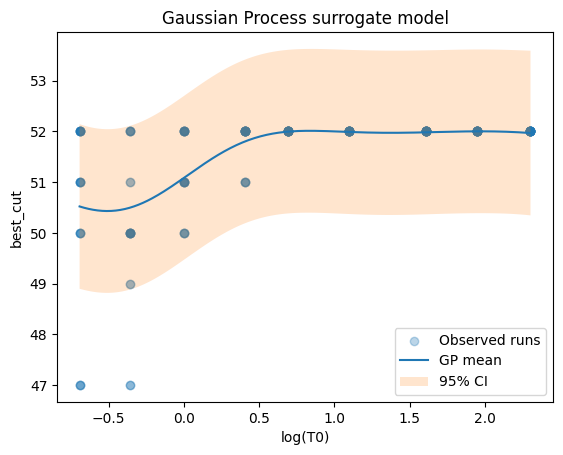

In [6]:
x_grid = np.linspace(X_min, X_max, 300).reshape(-1, 1)
mu, sigma = gp.predict(x_grid, return_std=True)

plt.figure()
plt.scatter(X_bo, y_bo, alpha=0.3, label="Observed runs")
plt.plot(x_grid, mu, label="GP mean")
plt.fill_between(
    x_grid.ravel(),
    mu - 1.96 * sigma,
    mu + 1.96 * sigma,
    alpha=0.2,
    label="95% CI"
)
plt.xlabel("log(T0)")
plt.ylabel("best_cut")
plt.title("Gaussian Process surrogate model")
plt.legend()
plt.show()


In [14]:
from scipy.stats import norm

def expected_improvement(x, gp, y_best, xi=0.01):
    # x: array 1D (n,) o 2D (n,1)
    x = np.asarray(x).reshape(-1, 1)

    mu, sigma = gp.predict(x, return_std=True)  # mu: (n,), sigma: (n,)
    mu = mu.ravel()
    sigma = sigma.ravel()

    # Evitar división por cero
    sigma_safe = np.maximum(sigma, 1e-12)

    improvement = mu - y_best - xi
    Z = improvement / sigma_safe
    ei = improvement * norm.cdf(Z) + sigma_safe * norm.pdf(Z)

    # Donde sigma era 0, EI debe ser 0
    ei[sigma < 1e-12] = 0.0

    return ei


In [15]:
y_best_observed = y_bo.max()

x_candidates = np.linspace(X_min, X_max, 1000)
ei = expected_improvement(x_candidates, gp, y_best_observed)

x_next = x_candidates[np.argmax(ei)]
x_next

0.8392043627694737

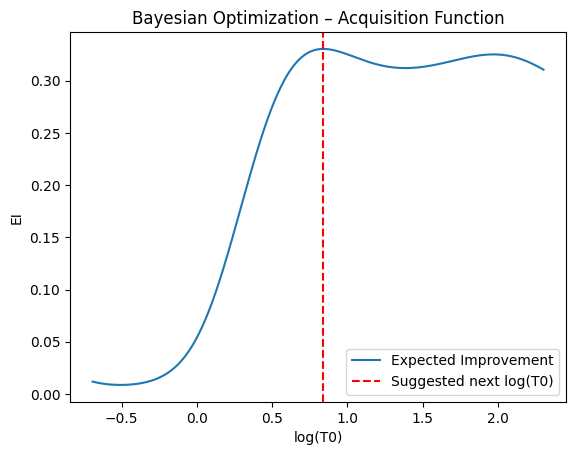

Suggested T0: 2.3145247219552516


In [16]:
plt.figure()
plt.plot(x_candidates, ei, label="Expected Improvement")
plt.axvline(x_next, color="red", linestyle="--", label="Suggested next log(T0)")
plt.xlabel("log(T0)")
plt.ylabel("EI")
plt.title("Bayesian Optimization – Acquisition Function")
plt.legend()
plt.show()

print("Suggested T0:", np.exp(x_next))


## Conclusions 
- The Gaussian Process surrogate captures a smooth, non-linear relationship between the initial temperature and solver performance, while explicitly modeling uncertainty due to stochasticity.
- The Expected Improvement acquisition function identifies a parameter region that balances exploitation of high-performing areas and residual uncertainty, suggesting efficient hyperparameter refinement.
